# Problem 1

## ODE Equations

$$
\begin{aligned}
&\frac{d x_{1}}{d t}=v_{1} \\
&\frac{d x_{2}}{d t}=v_{2} \\
&\frac{d v_{1}}{d t}=u_{1} \\
&\frac{d v_{2}}{d t}=u_{2}
\end{aligned}
$$

## Collocation Equations

$$
\begin{aligned}
&1.5\left[\begin{array}{cc}
.75 & -.25 \\
1 & 0
\end{array}\right]\left[\begin{array}{l}
\frac{d x_{1}}{d t} \\
\frac{d x_{2}}{d t}
\end{array}\right]=\left[\begin{array}{l}
x_{1}-0 \\
x_{2}-0
\end{array}\right] \\
&1.5\left[\begin{array}{cc}
.75 & -.25 \\
1 & 0
\end{array}\right]\left[\begin{array}{l}
\frac{d v_{1}}{x_{t}} \\
\frac{d v_{2}}{d t}
\end{array}\right]=\left[\begin{array}{l}
v_{1}-1 \\
v_{2}-1
\end{array}\right]
\end{aligned}
$$

## KKT Conditions
$$
\begin{aligned}
&J=v_{2}^{2} \\
&\frac{\partial J}{\partial x}=2 v_{2}=0 \text { for optimum. } \\
&\Rightarrow v_{2}=0
\end{aligned}
$$

In [70]:
import numpy as np
N = 1.5 * np.array([[.75,-.25],[1,0]])

time = np.array([0.0, 0.75,1.5])

from scipy.optimize import fsolve

# multi start guess
for i in range(5):
    zGuess = np.random.uniform(-5,5,9) # initial guess at solution

    def myFunction(z):
        #unpack everything
        u1 = z[0]
        u2 = z[1]
        x1 = z[2]
        x2 = 1.0
        v1 = z[3]
        v2 = z[4]
        dx1 = z[5]
        dx2 = z[6]
        dv1 = z[7]
        dv2 = z[8]

        #useful forms
        x = np.array([x1,x2])
        v = np.array([v1,v2])
        dx = np.array([dx1,dx2])
        dv = np.array([dv1,dv2])

        F = np.empty(9)

        #ode equations, solved for 0
        F[0] = dx1 - v1
        F[1] = dx2 - v2
        F[2] = dv1 - u1
        F[3] = dv2 - u2

        #collocation equations
        F[4:6] = N @ dx - (x - np.zeros(2))
        F[6:8] = N @ dv - (v - np.ones(2))

        #kkt condition
        F[-1] = v2
        return F

    z = fsolve(myFunction,zGuess)
    z = np.round(z, 5)
    if np.isclose(z[4], 0):
        print('\nVALID SOLUTION')
        print('u1:',z[0])
        print('u2:',z[1])
        print('x1:',z[2])
        print('v1:',z[3])
        print('v2:',z[4])
        print('dx1:',z[5])
        print('dx2:',z[6])
        print('dv1:',z[7])
        print('dv2:',z[8])
    else:
        print("\nKKT Condition Not Met")



VALID SOLUTION
u1: -0.66667
u2: -1.11111
x1: 0.75
v1: 0.66667
v2: -0.0
dx1: 0.66667
dx2: -0.0
dv1: -0.66667
dv2: -1.11111

VALID SOLUTION
u1: -0.66667
u2: -1.11111
x1: 0.75
v1: 0.66667
v2: 0.0
dx1: 0.66667
dx2: 0.0
dv1: -0.66667
dv2: -1.11111

VALID SOLUTION
u1: -0.66667
u2: -1.11111
x1: 0.75
v1: 0.66667
v2: -0.0
dx1: 0.66667
dx2: -0.0
dv1: -0.66667
dv2: -1.11111

VALID SOLUTION
u1: -0.66667
u2: -1.11111
x1: 0.75
v1: 0.66667
v2: 0.0
dx1: 0.66667
dx2: -0.0
dv1: -0.66667
dv2: -1.11111

VALID SOLUTION
u1: -0.66667
u2: -1.11111
x1: 0.75
v1: 0.66667
v2: 0.0
dx1: 0.66667
dx2: 0.0
dv1: -0.66667
dv2: -1.11111


100%|██████████| 149/149 [00:32<00:00,  4.65it/s]


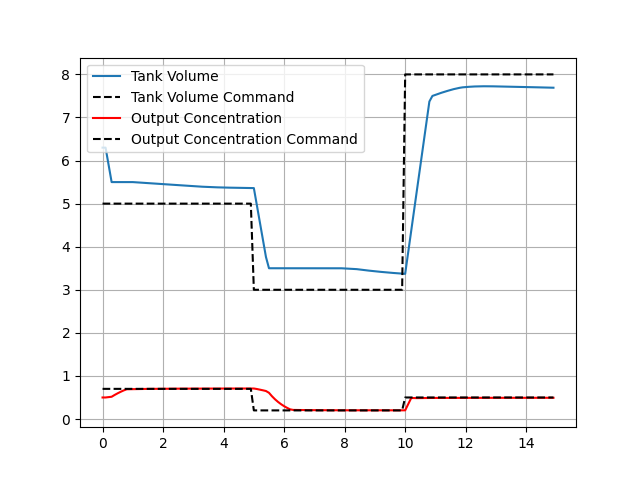

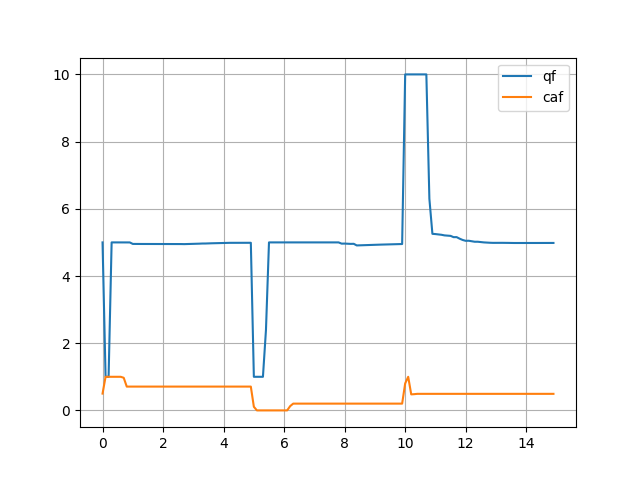

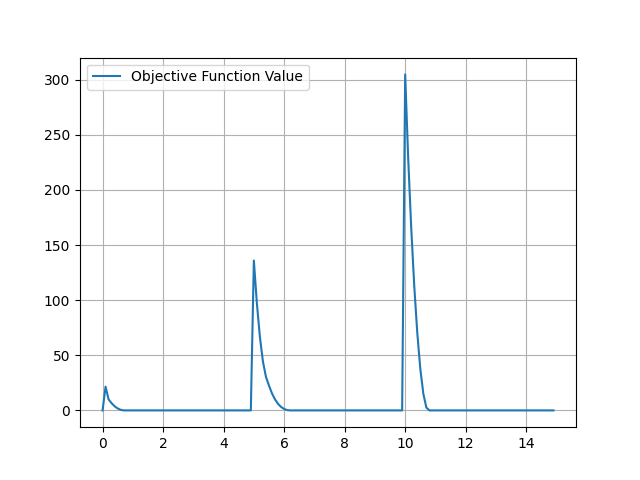

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from gekko import GEKKO
%matplotlib widget

# define process model x=[V,ca], u=[qf,caf]
def process(t,x,u):
    V = x[0]
    ca = x[1]
    qf = u[0]
    caf = u[1]

    q = 5
    v_dot = qf - q
    ca_dot = (caf*qf - ca*q -ca*v_dot)/V

    return [v_dot, ca_dot]


#%% GEKKO linear MPC
m = GEKKO()

#assume MPC horizon of 2 hours
m.time = np.linspace(0,2,21)

#manipulated variables
qf0 = 5
caf0 = 0.5
m.qf = m.MV(value = 5,lb=1,ub=10.0)
m.caf = m.MV(value = 0.5,lb=0,ub=1.0)

#MV tuning
m.qf.STATUS = 1
m.qf.FSTATUS = 0
m.caf.DCOST = .01


m.caf.STATUS = 1
m.caf.FSTATUS = 0
m.caf.DMAX = 0.6
m.caf.DCOST = .01

#controlled variables
m.V = m.CV(value = 6.3, lb=2, ub =8)
m.ca = m.CV(value = 0.5)

#deadbands
v_db = 0.5
ca_db = 0.01

#CV tuning
m.V.STATUS = 1
m.V.FSTATUS = 1

m.ca.STATUS = 1
m.ca.FSTATUS = 1


m.q = m.Const(5.0)

#eoms
m.Equation(m.V.dt() == m.qf - m.q)
m.Equation(m.ca*m.V.dt() + m.V*m.ca.dt() == m.caf*m.qf - m.ca*m.q)

#globals
m.options.CV_TYPE = 1
m.options.IMODE = 6
m.options.SOLVER = 3

#sanity check
# m.V.SP = 5.0
# m.ca.SP = 0.7
# m.solve(disp=False)

# plt.plot(m.time, m.V)
# plt.plot(m.time, m.ca)
# plt.plot(m.time, m.qf)
# plt.plot(m.time, m.caf)
# plt.show()

# Time Interval (hrs)
dt = .1
t = np.arange(0,15,dt)

# Set points
V_cmd =np.ones(int(15/dt))
V_cmd[0:int(5/dt)] = 5.0
V_cmd[int(5/dt):int(10/dt)] = 3.0
V_cmd[int(10/dt):] = 8.0

ca_cmd = np.ones(int(15/dt))
ca_cmd[0:int(5/dt)] = .7
ca_cmd[int(5/dt):int(10/dt)] = 0.2
ca_cmd[int(10/dt):] = 0.5

#initial conditions
x = np.array([6.3, 0.5])

#history
V_hist = [6.3]
ca_hist = [0.5]
qf_hist = [qf0]
caf_hist = [caf0]
obj_val_hist = [0]

# Simulate 
from tqdm import tqdm
for i in tqdm(range(len(t)-1)):
    # simulate one time period (one hour)
    ts = (t[i],t[i+1])
    # print(f'\nSim Time {ts}')

    #simulate plant
    sol = solve_ivp(process,ts,x,args=([qf_hist[i], caf_hist[i]],),max_step=.1)

    # get controlled variable measurements from simulation
    V_hist.append(sol.y[0,-1])
    ca_hist.append(sol.y[1,-1])

    # insert CV measurements
    m.V.MEAS = V_hist[i+1]
    m.ca.MEAS = ca_hist[i+1]

    # update initial conditions
    x[0] = V_hist[i+1]
    x[1] = ca_hist[i+1]
    
    # update setpoints for CVs (with deadbands)
    m.V.SPHI = V_cmd[i+1] + v_db
    m.V.SPLO = V_cmd[i+1] - v_db
    # m.V.SP = V_cmd[i+1] #need to add these when I use CV_TYPE=2, just SPHI doesn't work.
    m.ca.SPHI = ca_cmd[i+1] + ca_db
    m.ca.SPLO = ca_cmd[i+1] - ca_db
    # m.ca.SP = ca_cmd[i+1]
    # print(f"Volume Setpoint: {m.V.SP}")
    # print(f"Conc Setpoint: {m.ca.SP}")

    # solve MPC
    m.solve(disp=False)
    # print(m.qf.VALUE)

    # retrieve new manipulated vars values from optimization
    qf_hist.append(m.qf.NEWVAL)
    caf_hist.append(m.caf.NEWVAL)
    # print(f"Input Values: {m.qf.NEWVAL}, {m.caf.NEWVAL}")

    obj_val_hist.append(m.options.OBJFCNVAL)


# Create plot
plt.figure()
plt.plot(t, V_hist, label="Tank Volume")
plt.plot(t, V_cmd, '--k', label="Tank Volume Command")
plt.plot(t, ca_hist, 'r', label='Output Concentration')
plt.plot(t, ca_cmd, '--k', label='Output Concentration Command')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, qf_hist, label='qf')
plt.plot(t, caf_hist, label='caf')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, obj_val_hist, label='Objective Function Value')
plt.legend()
plt.grid(True)


In [72]:
#check max deviation
np.max(np.diff(caf_hist))

0.6000000103500001

Performance Requirements:

1) Outlet concentration should be faster than volume while respecting volume target and constraints.

* Default TR_INIT and TAU do just fine for all CVs. Could tune this to be less aggressive on the qf input, but per problem statement, we don't have costs or constraints on this input like we do on caf. 
* The minor exception to this is the transition at 5 hrs. Volume reaches it's set point faster than caf does (likely due to the caf saturation at 0 for that time period.) But for both other transitions, the caf response is much faster. 

2) Transitions should occur within 2 hours (ie ss reached within 2 hours).
* This is clearly satisfied for all CVs. Longest response to reach setpoint (and deadband) is about 1.25 hrs. 

3) Transitions don't start before scheduled time.
* This is satisfied.

4) Volume must never go below 2 m3 or above 8 m3.
* Satisfied with constraints on the volume CV. lb = 2 and ub = 8. Controller takes advantage of deadband to not approach upper limit when command is 8 on volume. 

5) caf rate limit less than .6.
* Satisfied with rate limit of .6. Max change on caf check is barely above .6 due to numerical error. Could fix this by making limit .59999.

Solution is optimal because of the cost function plot. As the set point changes, the error increases sharply (which is expected), but quickly converges to near 0 indicating little to no error on CV tracking.

# Problem 3

$$
\begin{aligned}
&\max _{u_{1}, u_{2}} x_{4}\left(t_{f}\right) x_{1}\left(t_{f}\right)\\
\text { s.t. } \\
&\frac{d x_{1}}{d t}=u_{1}+u_{2}\\
&w_{1}=14.35+x_{3}+\frac{x_{3}^{2}}{111.5}\\
&x_{1} \frac{d x_{2}}{d t}=g_{1} x_{1} x_{2}-\left(u_{1}+u_{2}\right) x_{2}\\
&w_{2}=0.22+x_{5}\\
&x_{1} \frac{d x_{3}}{d t}=u_{1} c_{1}-\left(u_{1}+u_{2}\right) x_{3}-\frac{g_{1} x_{1} x_{2}}{c_{2}} \\
&w_{3}=\frac{0.22 x_{7}}{w_{2}}+x_{6}\\
&x_{1} \frac{d x_{4}}{d t}=g_{2} x_{1} x_{2}-\left(u_{1}+u_{2}\right) x_{4}\\
&g_{1}=\frac{x_{3} w_{3}}{w_{1}}\\
&x_{1} \frac{d x_{5}}{d t}=u_{2} c_{3}-\left(u_{1}+u_{2}\right) x_{5}\\
&g_{2}=0.233 \frac{x_{3}}{w_{1}} \frac{\left(0.0005+x_{5}\right)}{\left(0.022+x_{5}\right)}\\
&\frac{d x_{6}}{d t}=-g_{3} x_{6}\\
&d x_{7}=-g_{3} x_{6}=g_{3}=0.09 \frac{x_{5}}{0.034+x_{5}}\\
&\frac{d x_{7}}{d t}=g_{3}\left(1-x_{7}\right) \\
&0 \leq u_{1}, u_{2} \leq 1\\
&c_{1}=100, c_{2}=0.51, c_{3}=4 \\
&0 \leq x_{1}, x_{2}, x_{3}, x_{4}, x_{5}, x_{6}, x_{7} \leq 100
\end{aligned}
$$


Number nodes: 6
Number time points: 11
Total Product: 2.5132205881

Number nodes: 6
Number time points: 51
Total Product: 3.5149002506

Number nodes: 6
Number time points: 101
Total Product: 4.2240231377

Number nodes: 6
Number time points: 301
Total Product: 5.2237991895

Number nodes: 6
Number time points: 501
Total Product: 5.4455356033


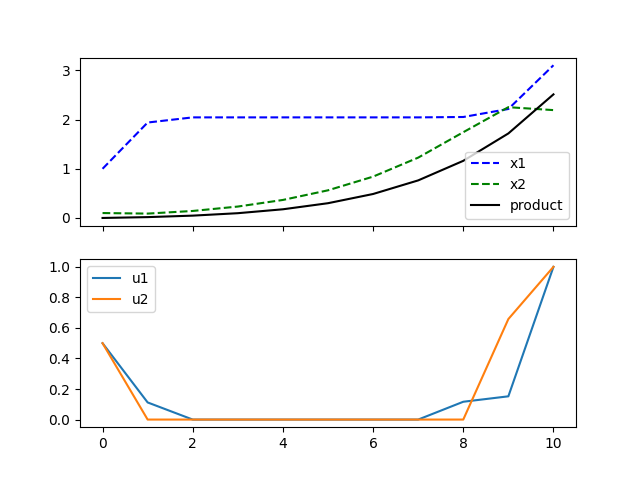

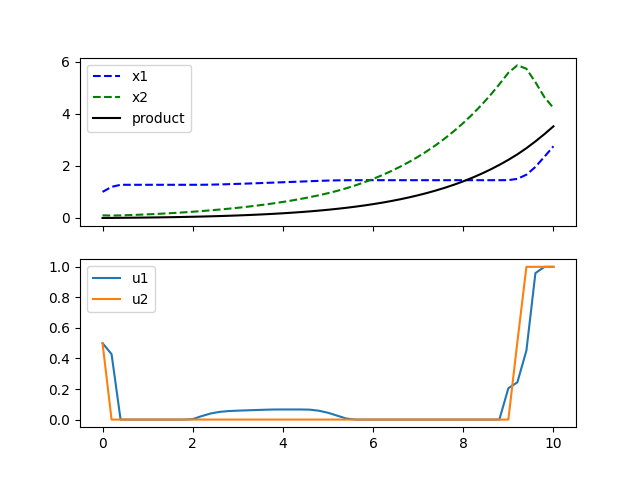

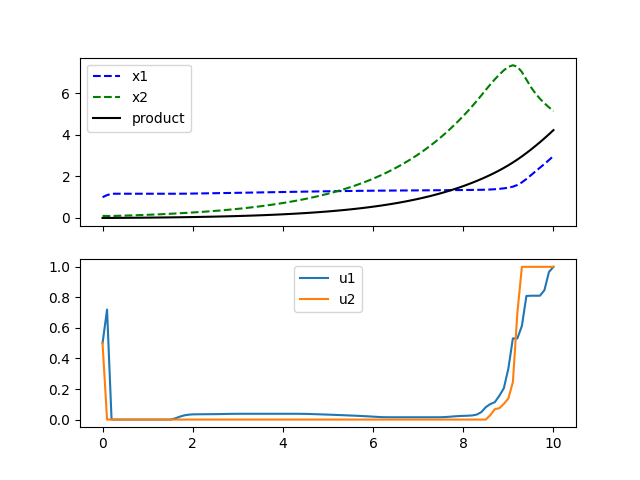

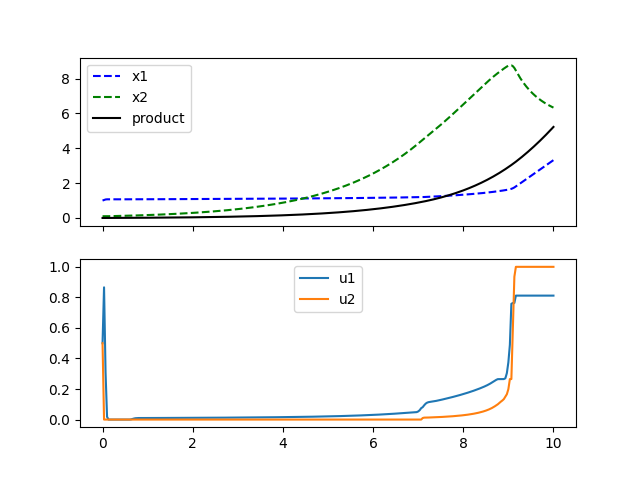

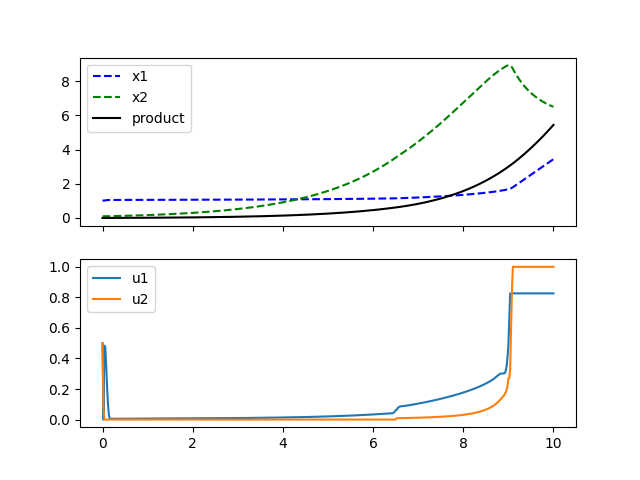

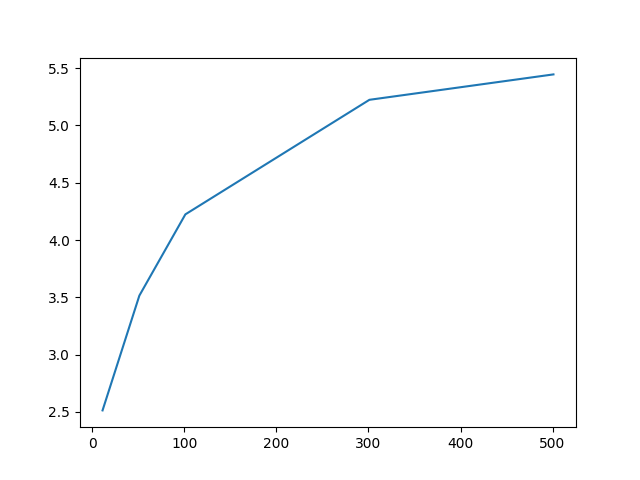

In [73]:
from gekko import GEKKO
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

N = [11,51,101, 301, 501]
product_hist = []
for i,n in enumerate(N):

    m = GEKKO()

    tf = 10
    m.time = np.linspace(0,tf,n)

    #dynamic variables and their ICs and bounds
    x1 = m.Var(1,lb=0, ub=100)
    x2 = m.Var(.1,lb=0, ub=100)
    x3 = m.Var(40,lb=0, ub=100)
    x4 = m.Var(0,lb=0, ub=100)
    x5 = m.Var(0,lb=0, ub=100)
    x6 = m.Var(1,lb=0, ub=100)
    x7 = m.Var(0,lb=0, ub=100)

    #intermediates
    w1 = m.Intermediate(14.35 + x3 + x3**2/111.5)
    w2 = m.Intermediate(.22 + x5)
    w3 = m.Intermediate((.22*x7)/w2 + x6)
    g1 = m.Intermediate(x3*w3/w1)
    g2 = m.Intermediate((.233*x3*(.0005 + x5))/(w1*(.022+x5)))
    g3 = m.Intermediate(.09*x5/(.034+x5))
    prod = m.Intermediate(x4*x1)

    #constants
    c1 = m.Const(100)
    c2 = m.Const(.51)
    c3 = m.Const(4)

    #inputs
    u1 = m.MV(0.5, lb=0, ub=1)
    u2 = m.MV(0.5, lb=0, ub=1)
    u1.STATUS = 1
    u2.STATUS = 1

    #dynamic equations
    m.Equation(x1.dt() == u1+u2)
    m.Equation(x1*x2.dt() == g1*x1*x2 - (u1 + u2)*x2)
    m.Equation(x1*x3.dt() == u1*c1 - (u1+u2)*x3 - (g1*x1*x2)/c2)
    m.Equation(x1*x4.dt() == g2*x1*x2 - (u1+u2)*x4)
    m.Equation(x1*x5.dt() == u2*c3 - (u1+u2)*x5)
    m.Equation(x6.dt() == -g3*x6)
    m.Equation(x7.dt() == g3*(1-x7))

    p = np.zeros(n)
    p[-1] = 1
    final = m.Param(p)

    #product_histective
    m.Maximize(final*prod)

    m.options.IMODE = 6
    m.options.NODES = 6

    m.solve(disp=False)


    print(f'\nNumber nodes: {m.options.NODES}')
    print(f'Number time points: {n}')
    print(f'Total Product: {-m.options.OBJFCNVAL}')
    product_hist.append(-m.options.OBJFCNVAL)

    fig,ax = plt.subplots(2,1, sharex=True)
    ax[0].plot(m.time, x1, '--b', label='x1')
    ax[0].plot(m.time, x2, '--g', label='x2')
    ax[0].plot(m.time, prod, '-k', label='product') 
    ax[0].legend()

    ax[1].plot(m.time, u1, label='u1')
    ax[1].plot(m.time, u2, label='u2')
    ax[1].legend()

plt.figure()
plt.plot(N,product_hist)


From the last plot of the objective value, the product at tf is converging to around 5.5. I could run more time points than 501, but that takes a long time. And the solution trajectories look almost identical between the 301 and 501 time point solutions. So this solution is accurate enough with 300-500 time points. 

Compared to the non-optimized trajectories given in the test, we improved production from 2.5 units to around 5.5